# Exploratory Spatio-Temporal Data Analysis


## Data Inspection 

### Load data

In [ ]:
import xarray as xr

# Path to your NetCDF file
file_path = 'drought-forecasting/modeling-pipeline/data/02_intermediate/estda.nc'

# Load the dataset
ds = xr.open_dataset(file_path, chunks="auto")

### Visualize variables on a map

In [24]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from typing import Optional

import dask.array as da

def visualize_variable_on_map(
    dataset: xr.Dataset,
    variable: str,
    time_dim: str = 'valid_time',
    lat_dim: str = 'latitude',
    lon_dim: str = 'longitude',
    plot_type: str = 'scatter_geo',
    downsample_factor: Optional[int] = 1,
    projection: str = 'natural earth',
    color_scale: Optional[list] = None,
    custom_boundaries: Optional[list] = None,
    title: Optional[str] = None,
    animation_frame: Optional[str] = None,
    hover_precision: int = 2,
    custom_colorbar_title: Optional[str] = None,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    **kwargs
) -> go.Figure:
    """
    Modified function to visualize variables in xarray.Dataset with dask support.
    """
    grib_name = dataset[variable].attrs.get("GRIB_name", variable)
    grib_units = dataset[variable].attrs.get("GRIB_units", "")
    if not title:
        title = f"{grib_name}"
        if start_date or end_date:
            title += f" ({start_date or ''} to {end_date or ''})"
    colorbar_title = custom_colorbar_title if custom_colorbar_title else grib_units

    da = dataset[variable]

    for dim in [time_dim, lat_dim, lon_dim]:
        if dim not in da.dims:
            raise ValueError(f"Dimension '{dim}' not found in variable '{variable}'.")

    if start_date or end_date:
        if start_date:
            da = da.sel({time_dim: da[time_dim] >= pd.to_datetime(start_date)})
        if end_date:
            da = da.sel({time_dim: da[time_dim] <= pd.to_datetime(end_date)})

    if downsample_factor > 1:
        da = da.coarsen({lat_dim: downsample_factor, lon_dim: downsample_factor}, boundary='trim').mean()

    if custom_boundaries and color_scale:
        boundaries = custom_boundaries
        cmap = mcolors.ListedColormap(color_scale)
        norm = mcolors.BoundaryNorm(boundaries, cmap.N)
        color_min, color_max = boundaries[0], boundaries[-1]
    else:
        # Approximate min and max with dask
        color_min = vmin if vmin is not None else float(da.min().compute())
        color_max = vmax if vmax is not None else float(da.max().compute())

    if plot_type == 'scatter_geo':
        df = da.to_dataframe().reset_index().dropna(subset=[variable])

        fig = px.scatter_geo(
            df,
            lat=lat_dim,
            lon=lon_dim,
            color=variable,
            animation_frame=animation_frame,
            projection=projection,
            color_continuous_scale=color_scale if not custom_boundaries else px.colors.make_colorscale(cmap.colors),
            title=title,
            labels={variable: grib_name},
            hover_data={variable: f":.{hover_precision}f"},
            range_color=(color_min, color_max),
            **kwargs
        )

        fig.update_layout(
            coloraxis_colorbar=dict(
                title=colorbar_title,
                ticks="outside"
            )
        )

    elif plot_type == 'imshow':
        z = da.mean(dim=time_dim).values
        if isinstance(z, da.Array):  # Ensure dask array is computed for imshow
            z = z.compute()
        if da[lat_dim][0] > da[lat_dim][-1]:
            z = z[::-1, :]

        fig = px.imshow(
            z,
            labels=dict(x=lon_dim, y=lat_dim, color=grib_name),
            x=da[lon_dim].values,
            y=da[lat_dim].values,
            color_continuous_scale=color_scale if not custom_boundaries else px.colors.make_colorscale(cmap.colors),
            title=title,
            range_color=(color_min, color_max),
            **kwargs
        )

        fig.update_layout(
            coloraxis_colorbar=dict(
                title=colorbar_title,
                ticks="outside"
            )
        )
    else:
        raise ValueError(f"Plot type '{plot_type}' is not supported.")

    return fig


In [66]:
# variable = 'cl'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Blues'
# )
# fig.show()

In [67]:
# variable = 'cvh'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'YlGn'
# )
# fig.show()

In [68]:
# variable = 'tvh'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Rainbow'
# )
# fig.show()

In [69]:
# variable = 'asn'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'ice'
# )
# fig.show()

In [70]:
# variable = 'sst'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Plasma'
# )
# fig.show()

In [71]:
# variable = 'slt'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Rainbow'
# )
# fig.show()

In [72]:
# variable = 'lai_hv'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'tempo'
# )
# fig.show()

In [73]:
# variable = 'tclw'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Blues'
# )
# fig.show()

In [74]:
# variable = 'tciw'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Greys_r'
# )
# fig.show()

In [75]:
# variable = 'z'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu_r'
# )
# fig.show()

In [76]:
# variable = 'sp'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Plasma'
# )
# fig.show()

In [77]:
# variable = 'msl'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdYlBu_r'
# )
# fig.show()

In [78]:
# variable = 'tcc'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'BuPu'
# )
# fig.show()

In [79]:
# variable = 'u10'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Bluered'
# )
# fig.show()

In [80]:
# variable = 'v10'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'Bluered'
# )
# fig.show()

In [81]:
# variable = 't2m'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu_r',
#     vmin=-20 + 273.15,
#     vmax=25 + 273.15,
# )
# fig.show()

In [82]:
# variable = 'd2m'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu_r',
#     vmin=-20 + 273.15,
#     vmax=25 + 273.15,
# )
# fig.show()

In [83]:
# variable = 'si10'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu_r'
# )
# fig.show()

In [84]:
# variable = 'e'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Reds_r'
# )
# fig.show()

In [85]:
# variable = 'ro'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'dense'
# )
# fig.show()

In [86]:
# variable = 'tp'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'viridis',
#     vmin=0,
#     vmax=50
# )
# fig.show()

In [87]:
# variable = 'pev'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Reds_r',
#     vmin=-10,
#     vmax=-4
# )
# fig.show()

In [88]:
# # Define custom boundaries and colors
# custom_boundaries = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
# custom_colors = ['darkred', 'red', 'orange', 'yellow', 'green', 'green', 'lightblue', 'blue', 'darkblue']

# # Call the function with the updated arguments
# variable = 'swvl1'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale=custom_colors,
#     custom_boundaries=custom_boundaries,
#     title='Volumetric Soil Water Layer 1'
# )

# fig.show()

In [90]:
# variable = 'tp_percent_of_normal'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=0,
#     vmax=200
# )
# fig.show()

In [91]:
# variable = 't2m_percent_of_normal'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=0,
#     vmax=200
# )
# fig.show()

In [92]:
# variable = 'swvl1_percent_of_normal'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=0,
#     vmax=200
# )
# fig.show()

In [93]:
# variable = 'tp_std_anomaly'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [94]:
# variable = 't2m_std_anomaly'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [95]:
# variable = 'pev_std_anomaly'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [96]:
# variable = 'swvl1_std_anomaly'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [97]:
# variable = 'tp_std_anomaly_land_only'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [98]:
# variable = 't2m_std_anomaly_land_only'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [99]:
# variable = 'pev_std_anomaly_land_only'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [100]:
# variable = 'tp_percent_of_normal_land_only'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=0,
#     vmax=200
# )
# fig.show()

In [101]:
# variable = 't2m_percent_of_normal_land_only'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=0,
#     vmax=200
# )
# fig.show()

In [102]:
# variable = 'tp_percent_of_normal_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=0,
#     vmax=200
# )
# fig.show()

In [103]:
# variable = 'tp_std_anomaly_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [104]:
# variable = 't2m_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu_r',
#     vmin=-20 + 273.15,
#     vmax=25 + 273.15,
# )
# fig.show()

In [105]:
# variable = 't2m_percent_of_normal_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu_r',
#     vmin=97.5,
#     vmax=102.5
# )
# fig.show()

In [106]:
# variable = 't2m_std_anomaly_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu_r',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [107]:
# variable = 'pev_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Reds_r',
#     vmin=-10,
#     vmax=-4
# )
# fig.show()

In [108]:
# variable = 'pev_std_anomaly_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [109]:
# # Define custom boundaries and colors
# custom_boundaries = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
# custom_colors = ['darkred', 'red', 'orange', 'yellow', 'green', 'green', 'lightblue', 'blue', 'darkblue']

# # Call the function with the updated arguments
# variable = 'swvl1_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale=custom_colors,
#     custom_boundaries=custom_boundaries,
#     title='Volumetric Soil Water Layer 1'
# )

# fig.show()

In [110]:
# variable = 'swvl1_percent_of_normal_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu_r',
#     vmin=50,
#     vmax=150
# )
# fig.show()

In [111]:
# variable = 'swvl1_std_anomaly_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

### Variables Distributions

In [117]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional

def plot_variable_distributions(ds: xr.Dataset, variables: Optional[List[str]] = None) -> None:
    """
    Plot the distribution of specified variables in the xarray Dataset.
    If no variables are specified, plot the distributions of all variables.

    Args:
        ds (xr.Dataset): The xarray dataset containing variables to visualize.
        variables (List[str], optional): List of variable names to plot.
                                         If None, plots all variables.
    """
    # Determine variables to plot
    variables_to_plot = variables if variables else list(ds.data_vars)
    
    for var in variables_to_plot:
        if var not in ds:
            print(f"Variable '{var}' not found in the dataset. Skipping.")
            continue
        
        data = ds[var].values.flatten()  # Flatten the data for distribution plot
        
        # Remove NaN values to avoid plotting issues
        data = data[~np.isnan(data)]
        
        plt.figure(figsize=(10, 5))
        plt.hist(data, bins=50, alpha=0.7, color='violet')
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

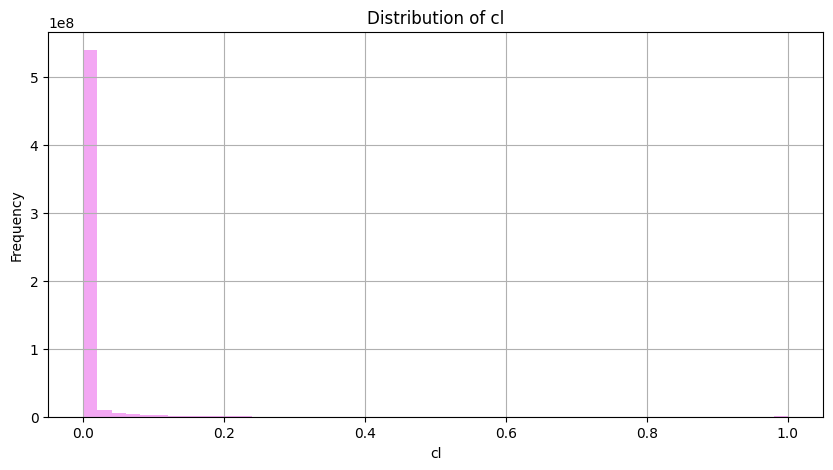

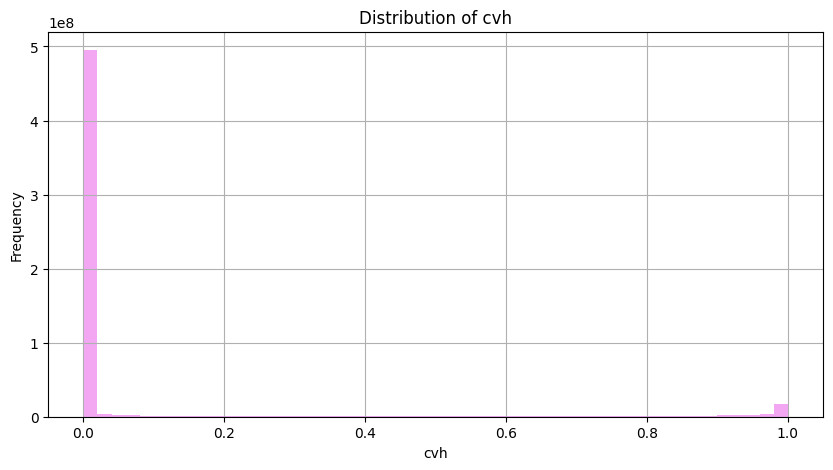

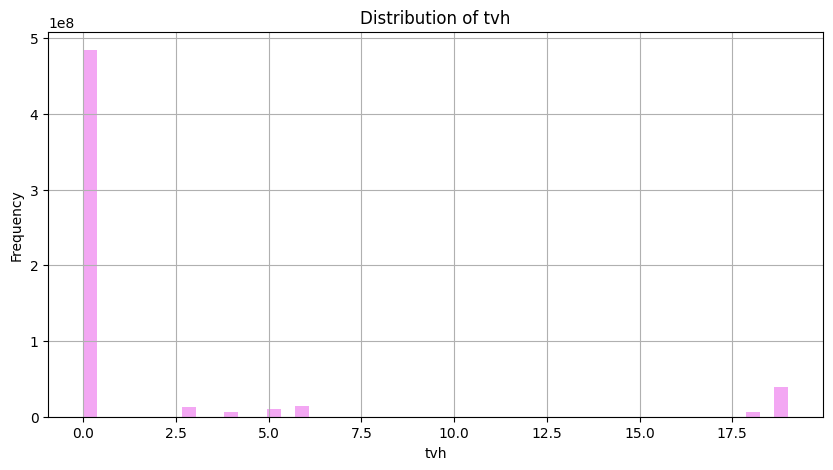

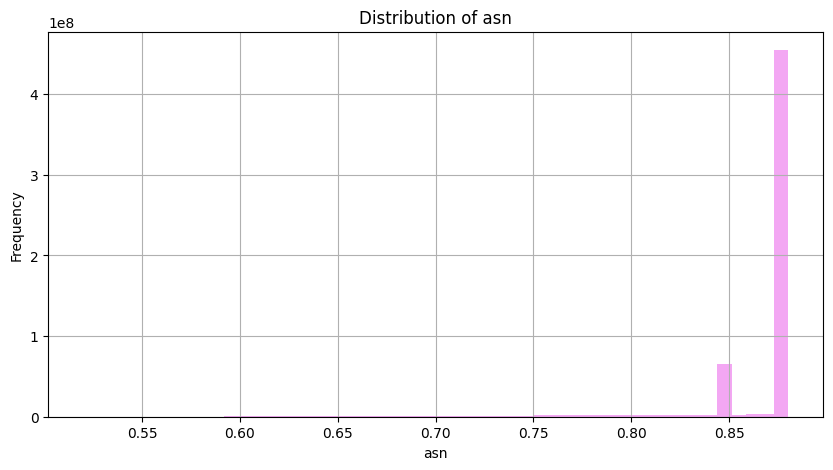

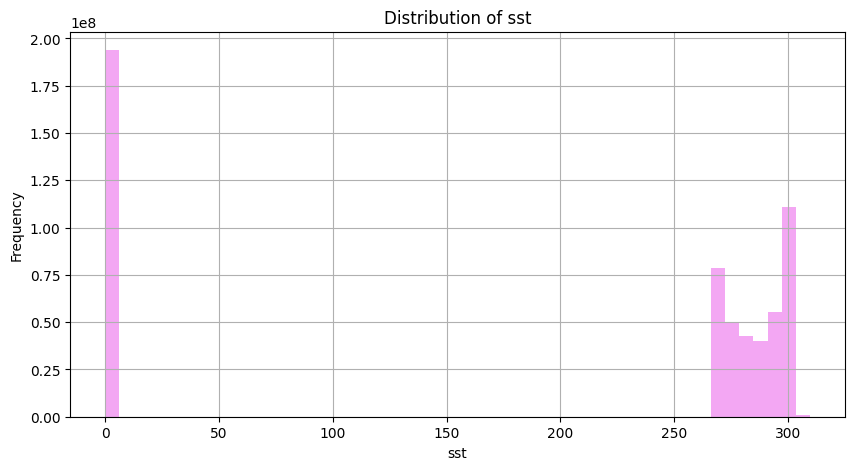

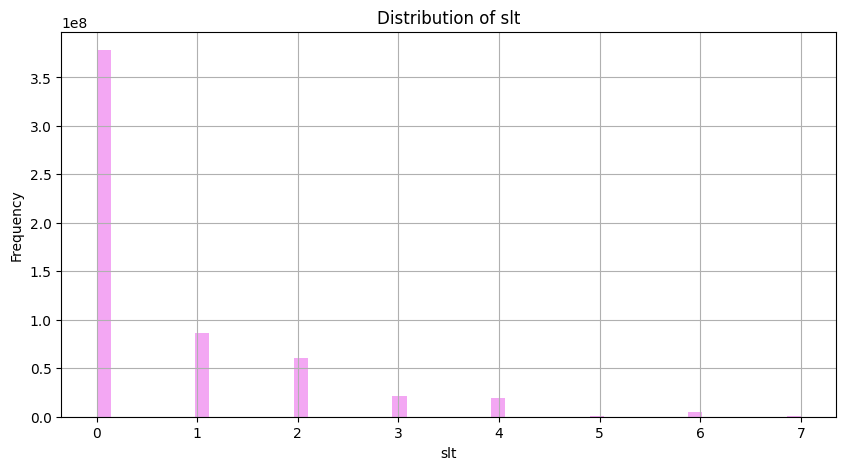

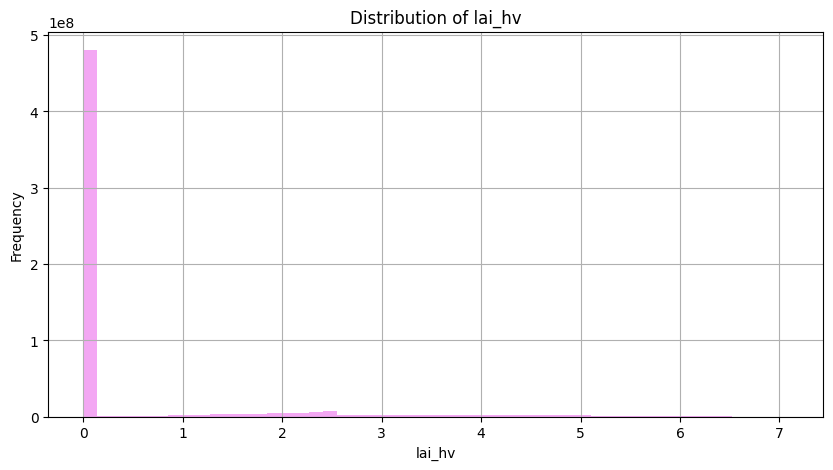

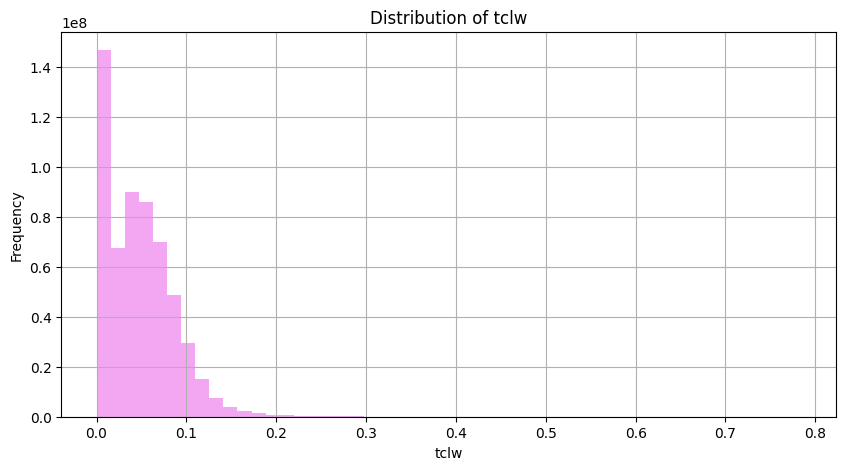

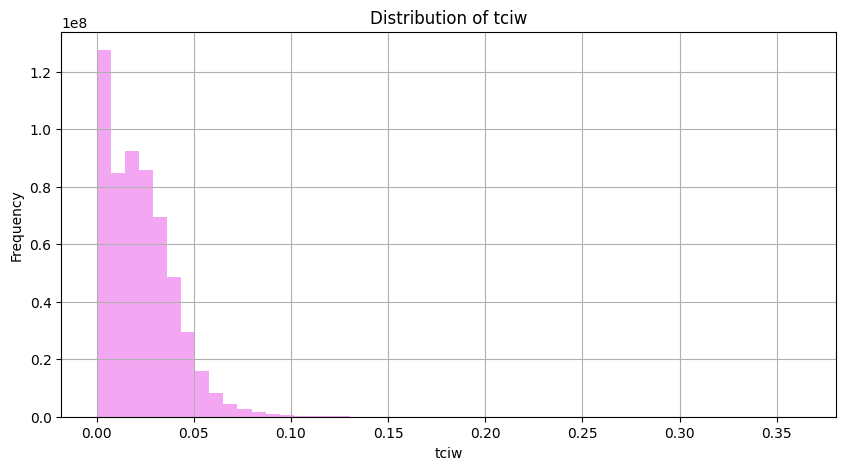

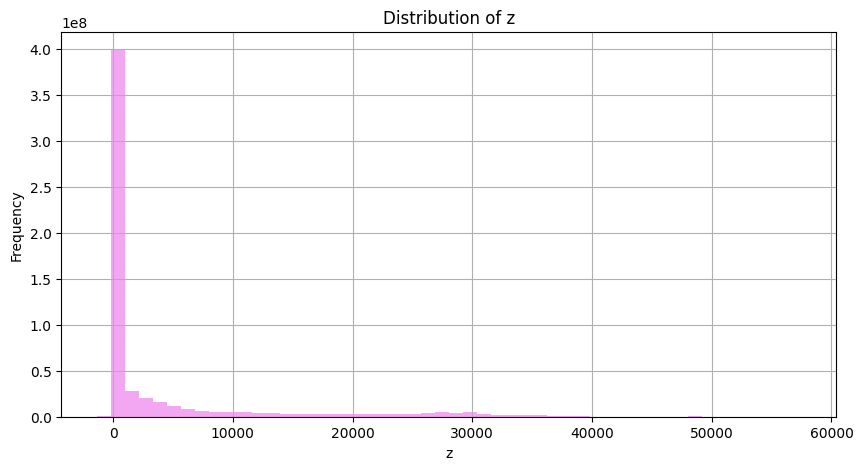

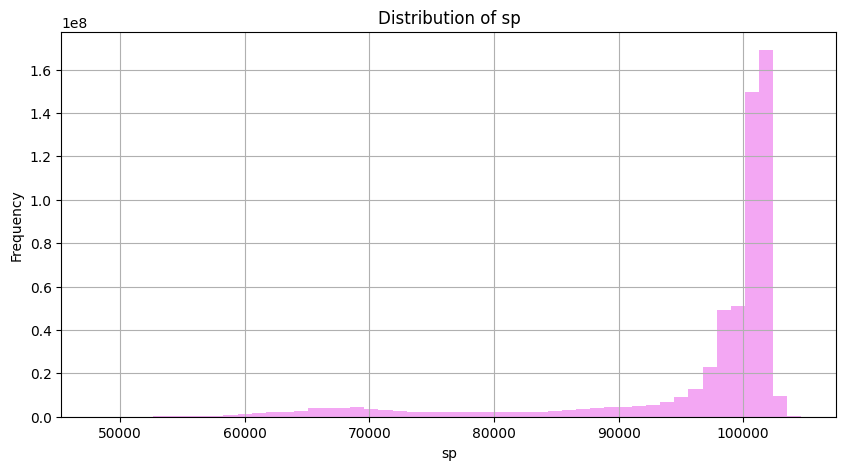

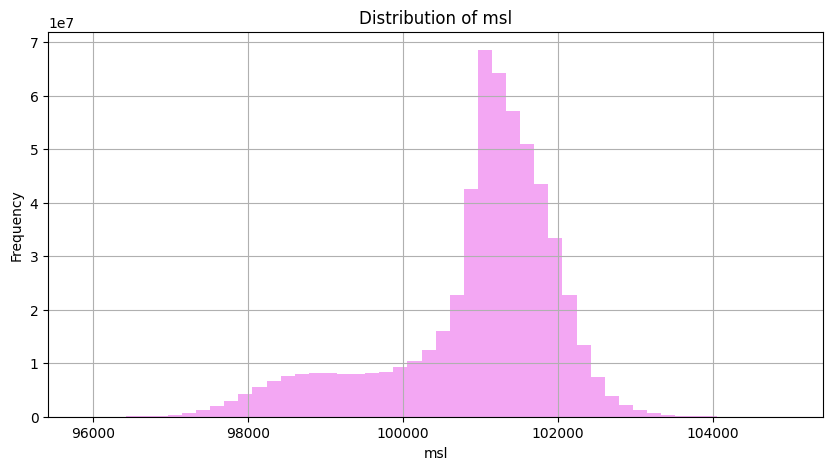

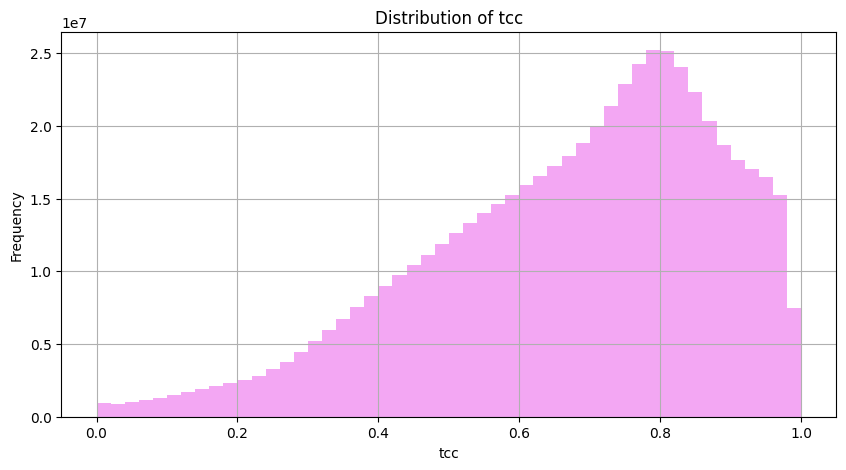

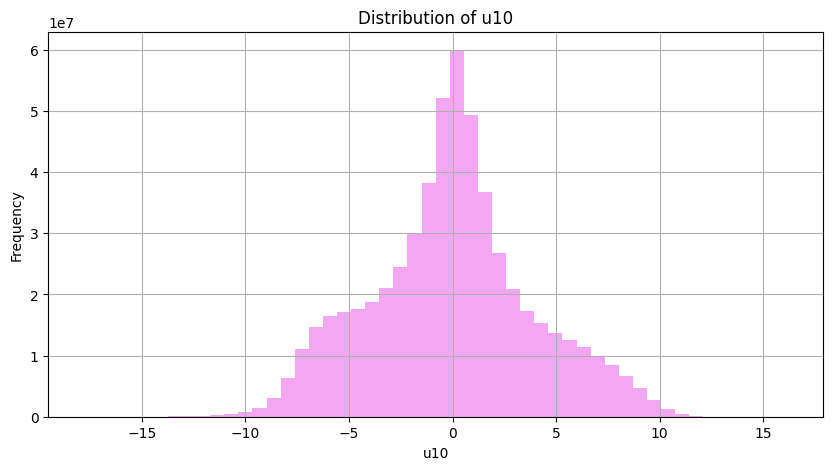

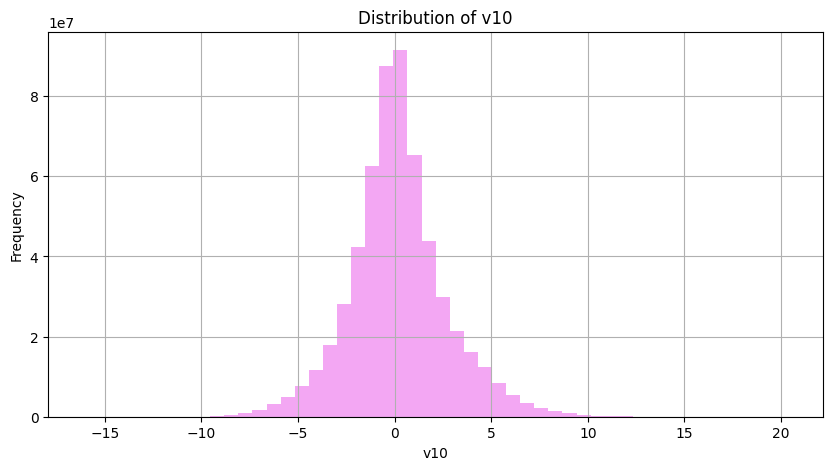

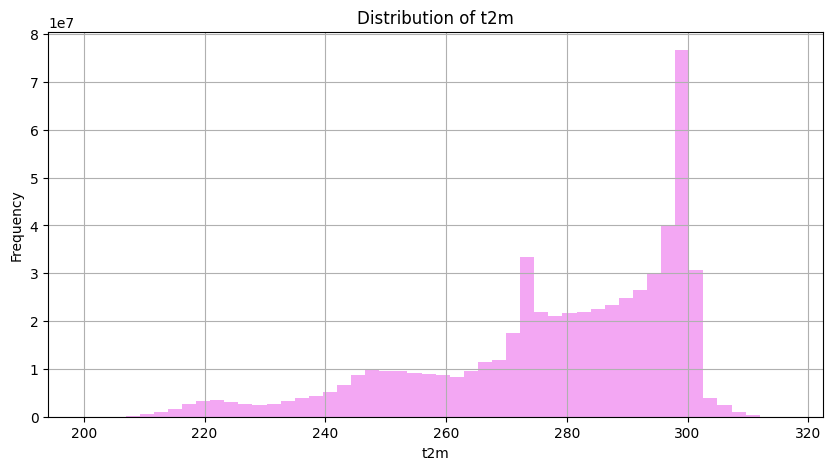

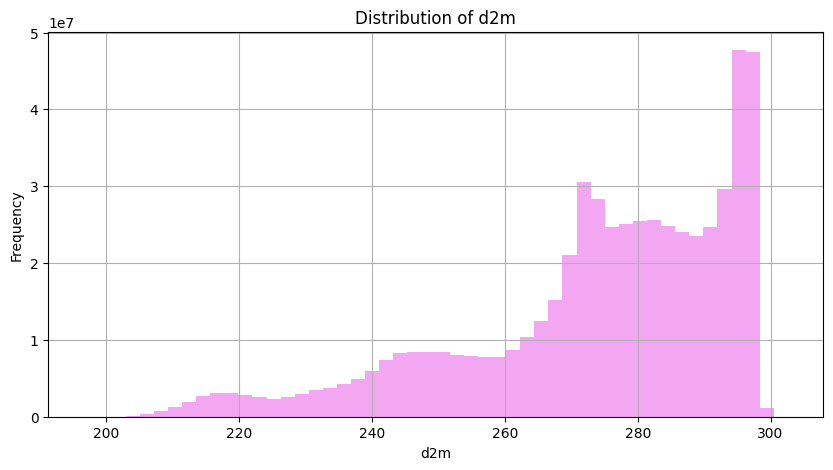

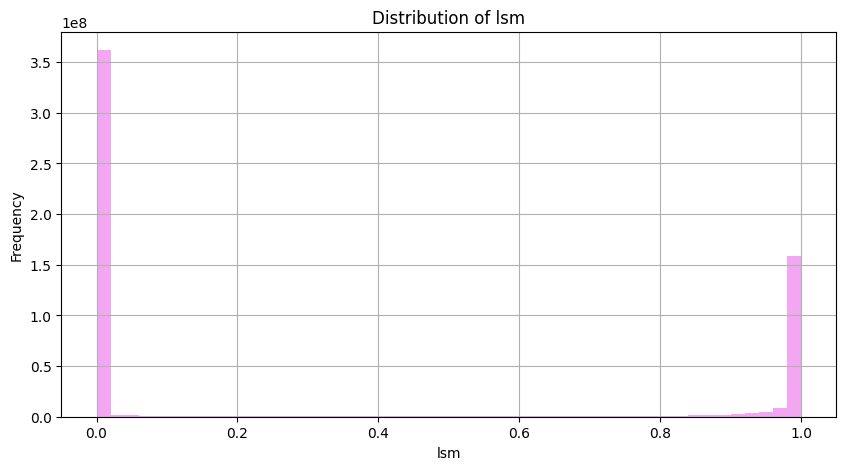

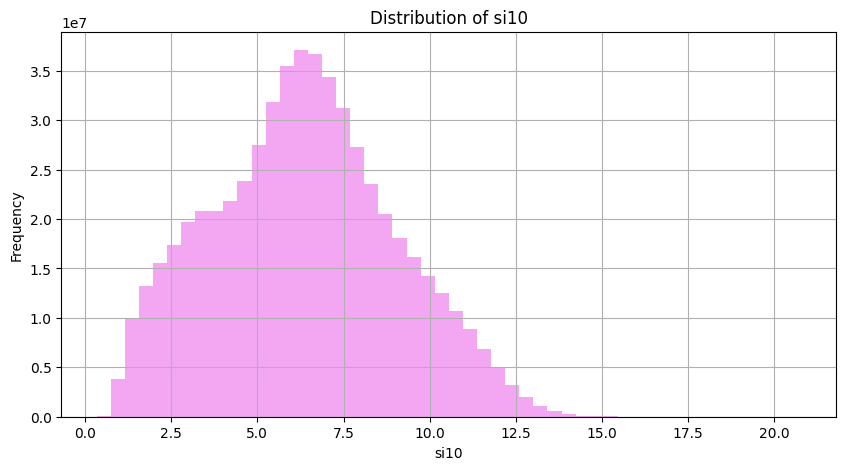

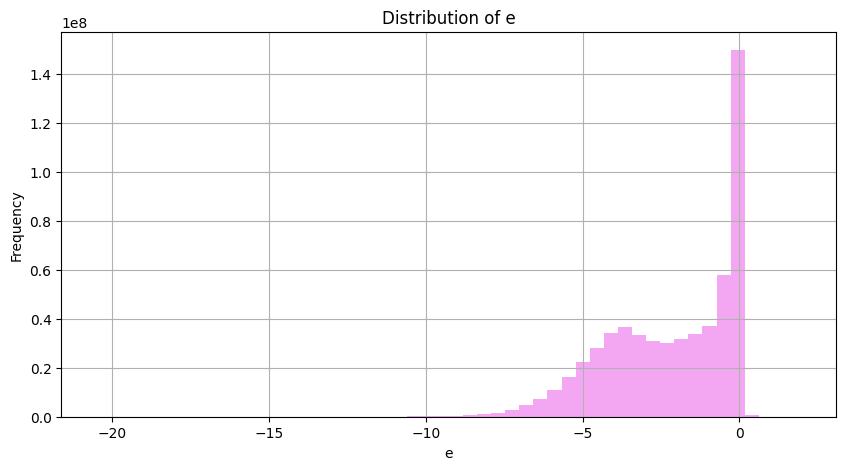

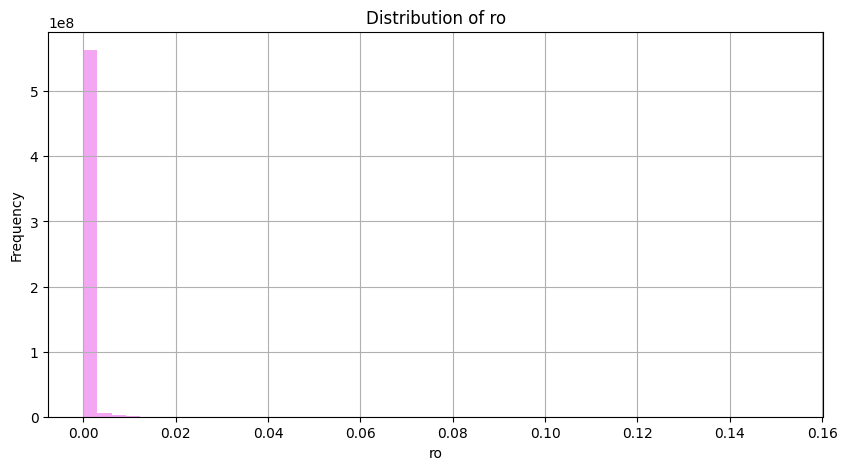

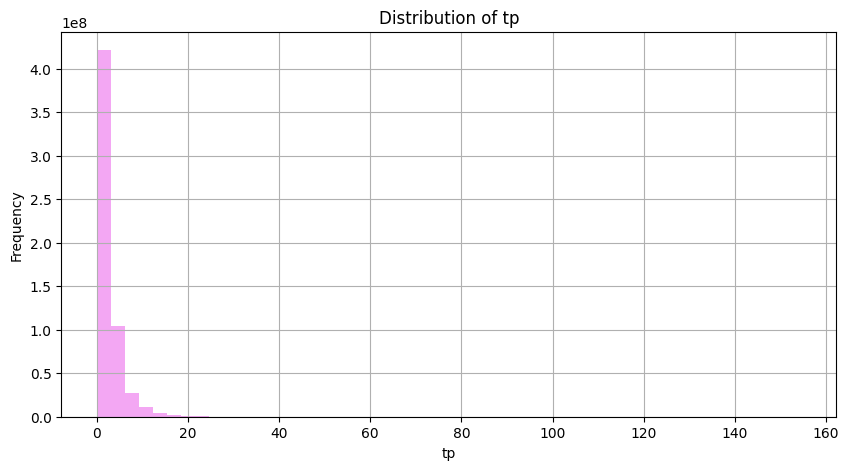

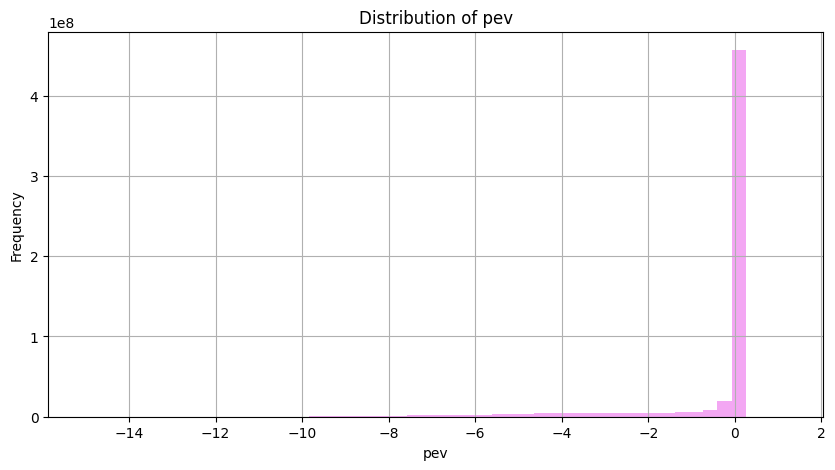

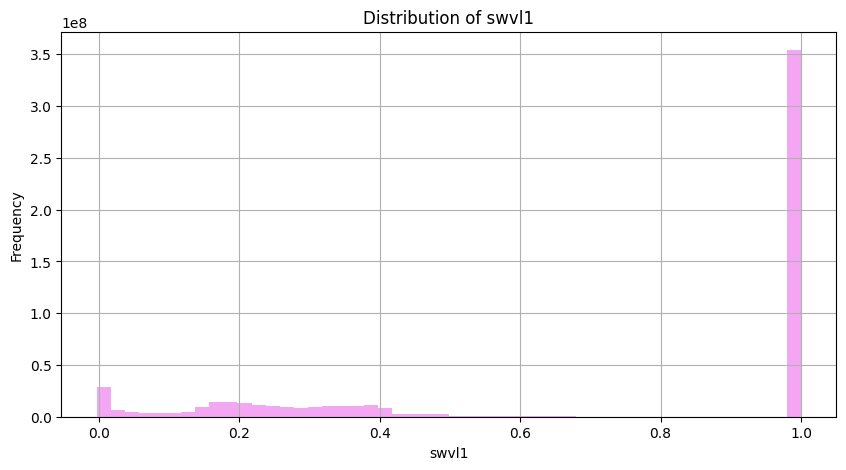

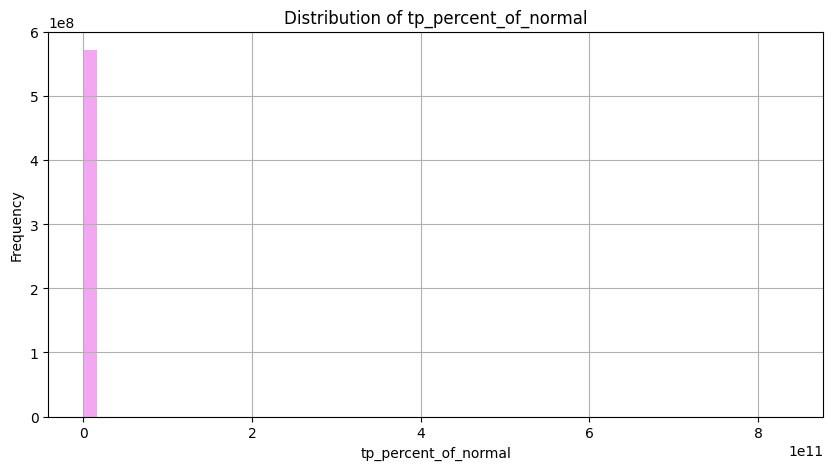

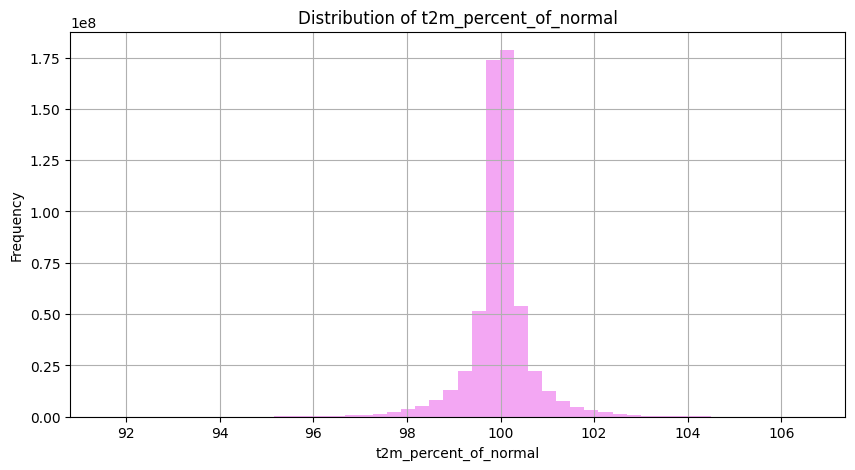

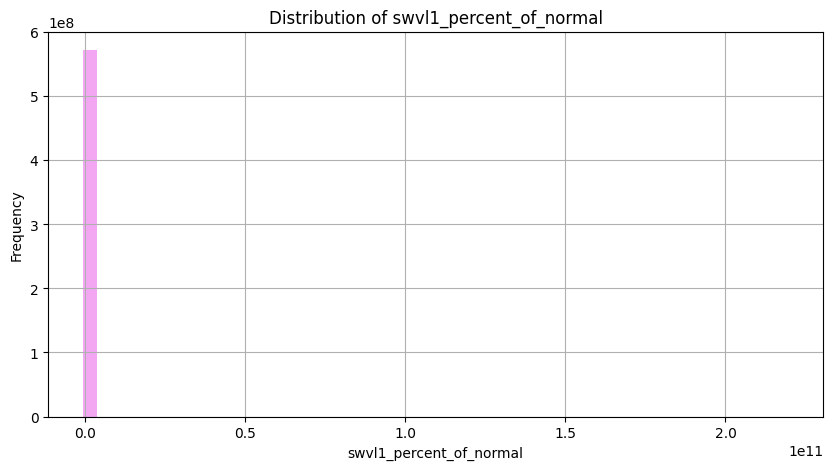

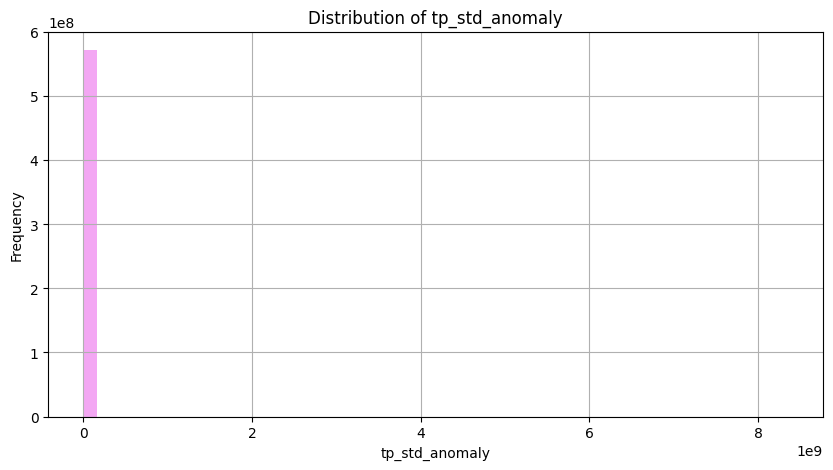

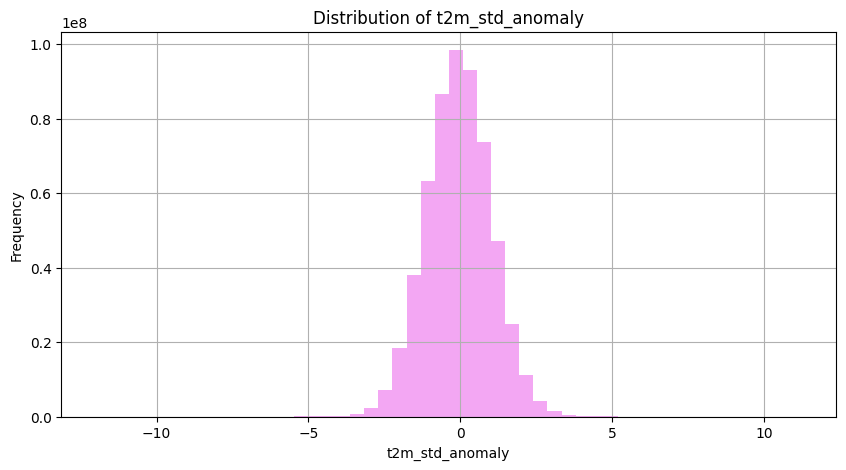

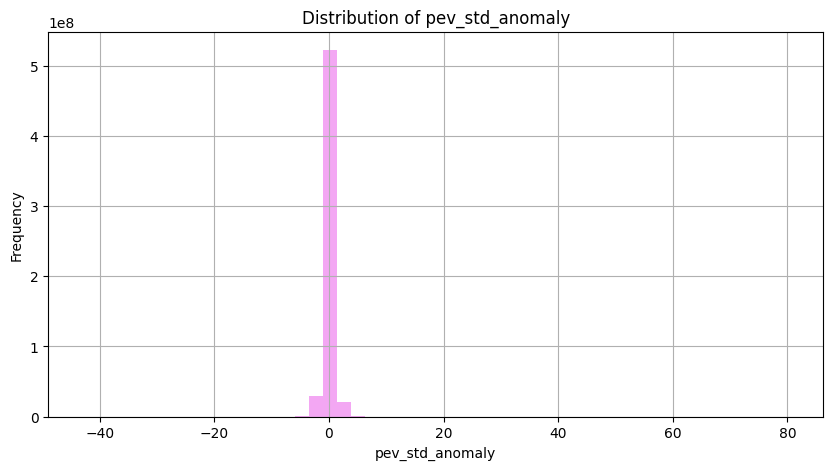

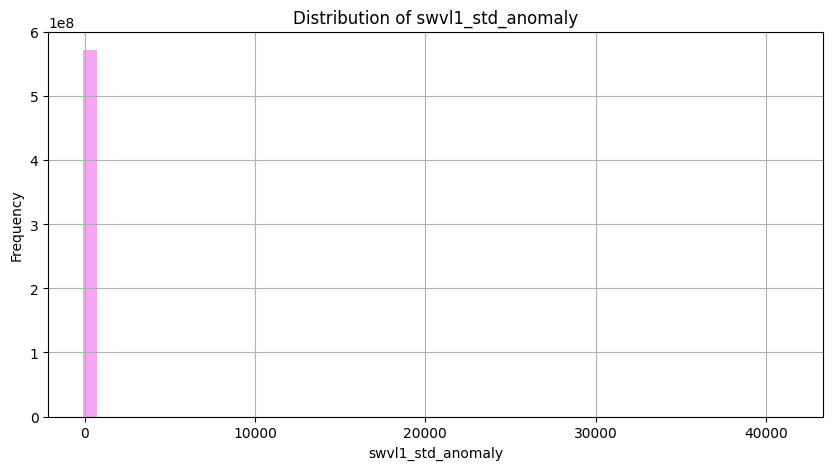

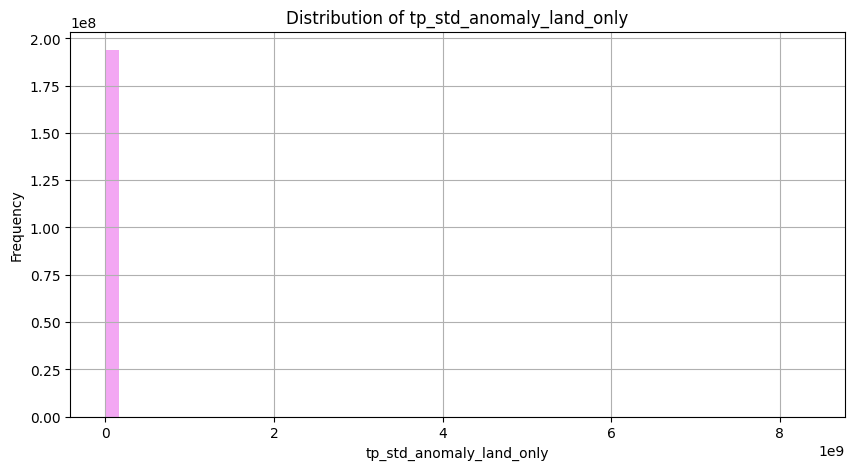

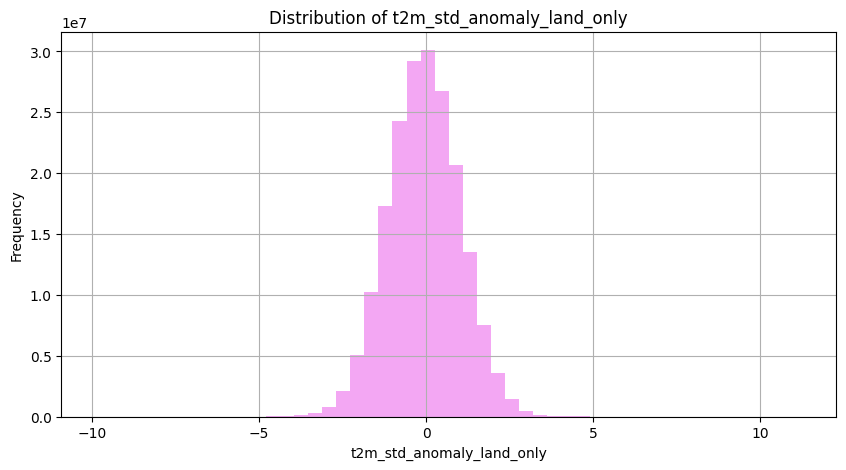

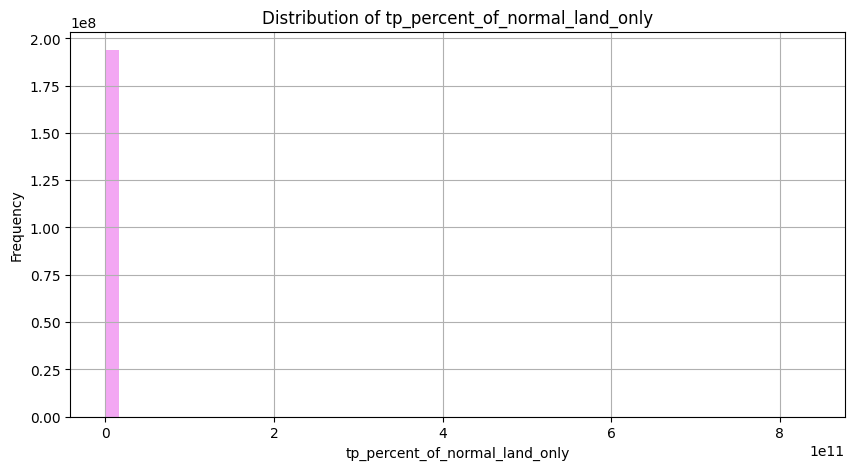

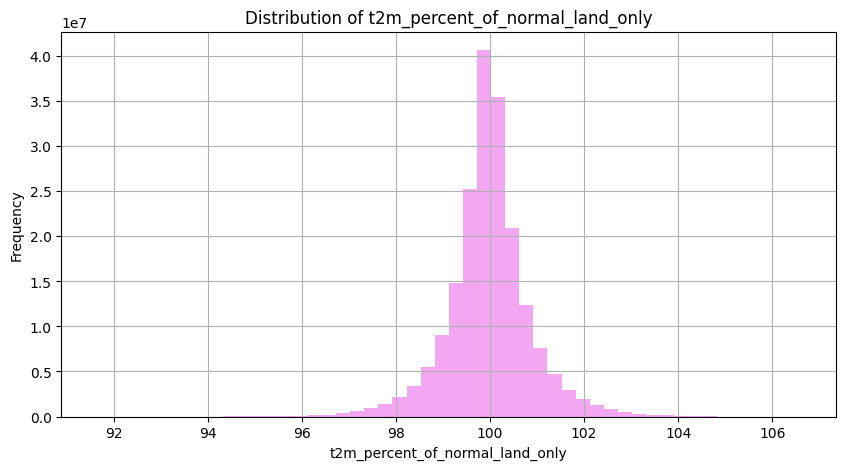

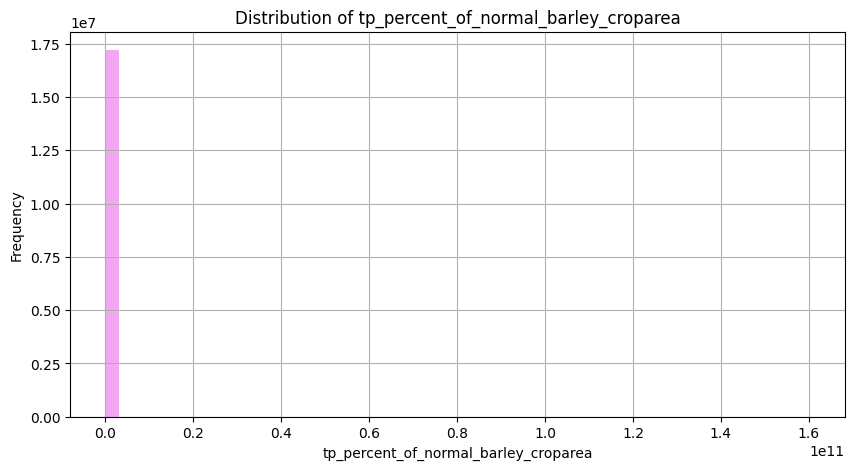

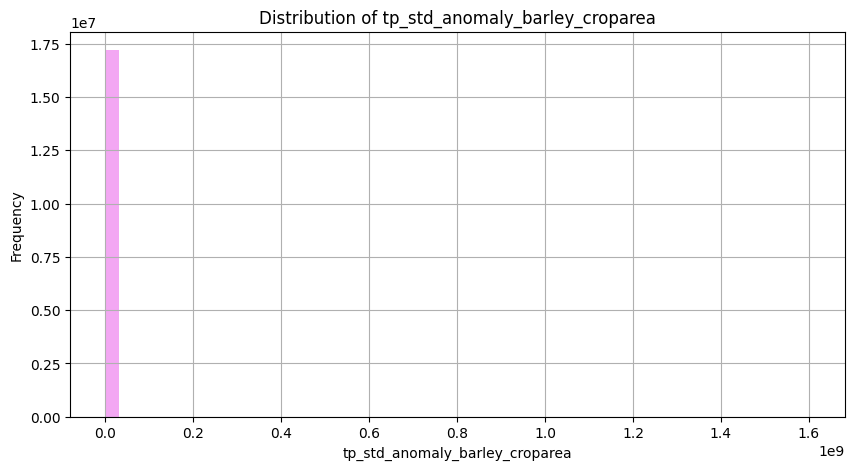

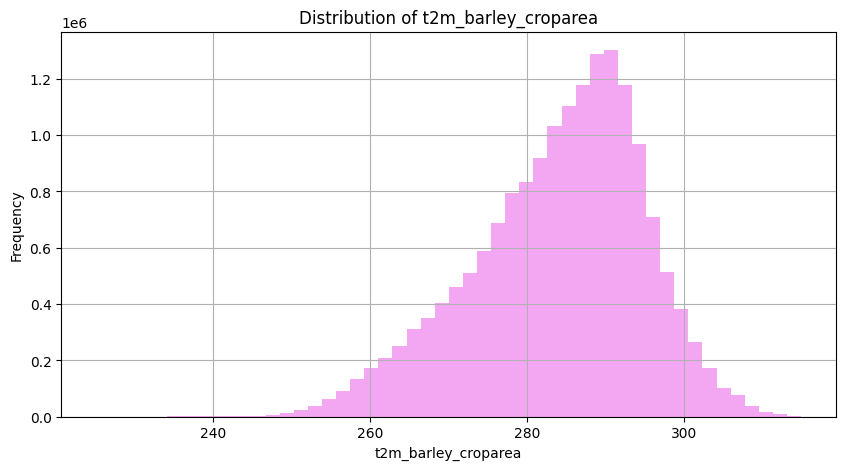

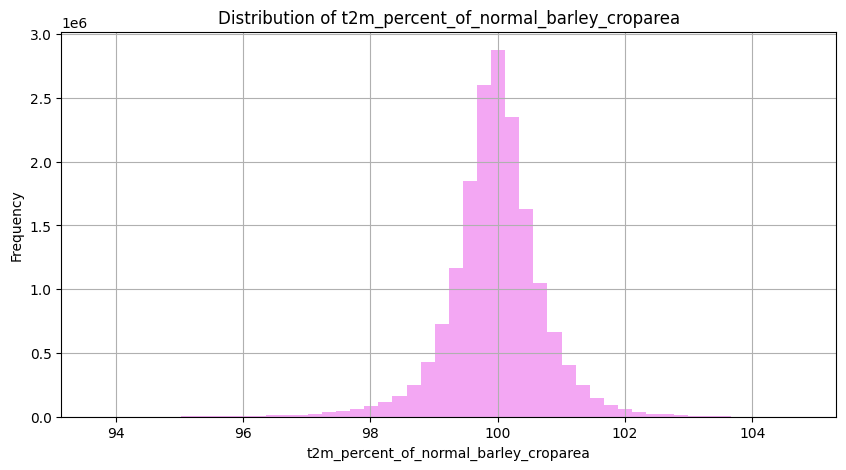

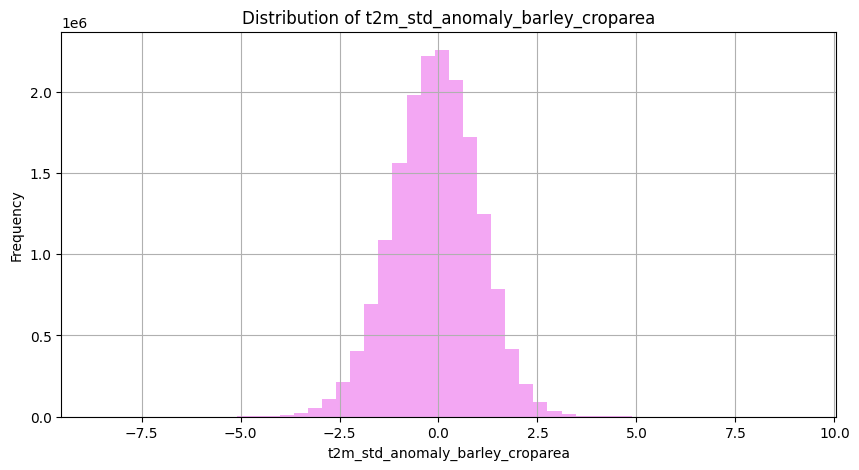

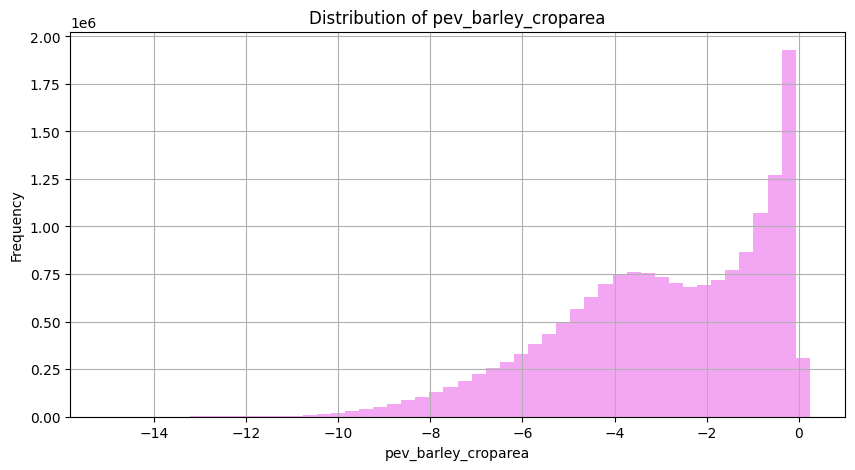

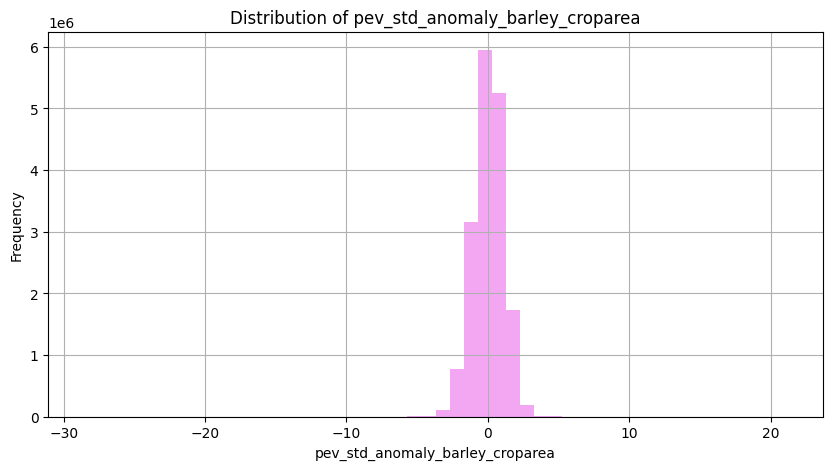

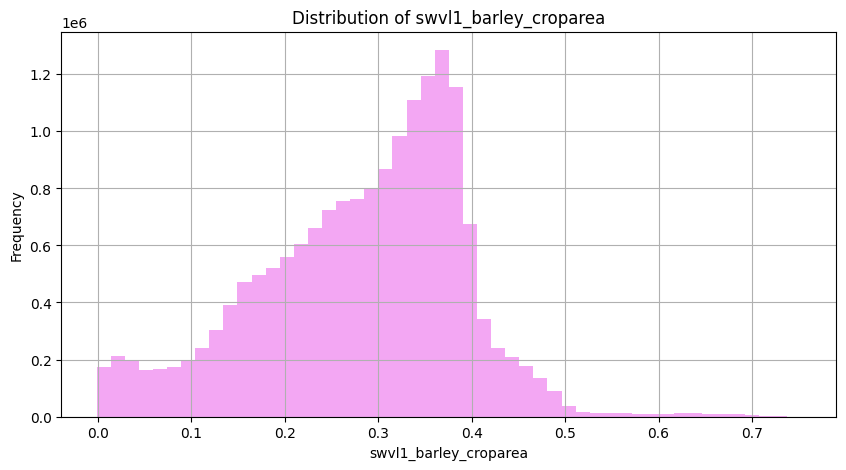

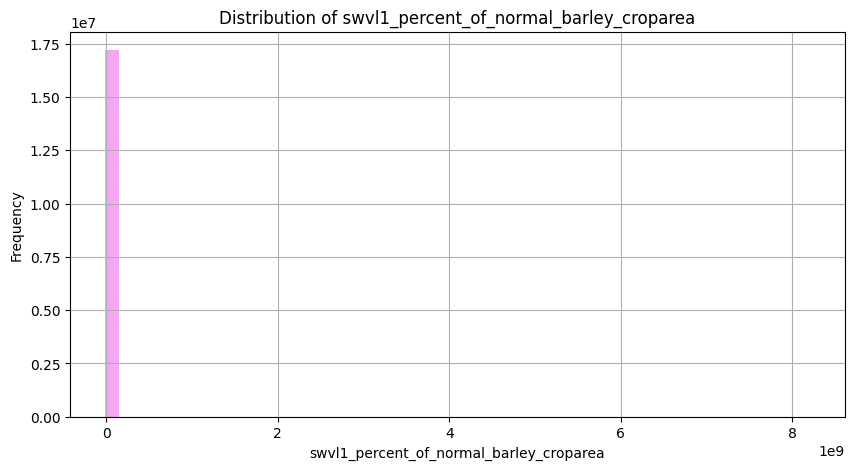

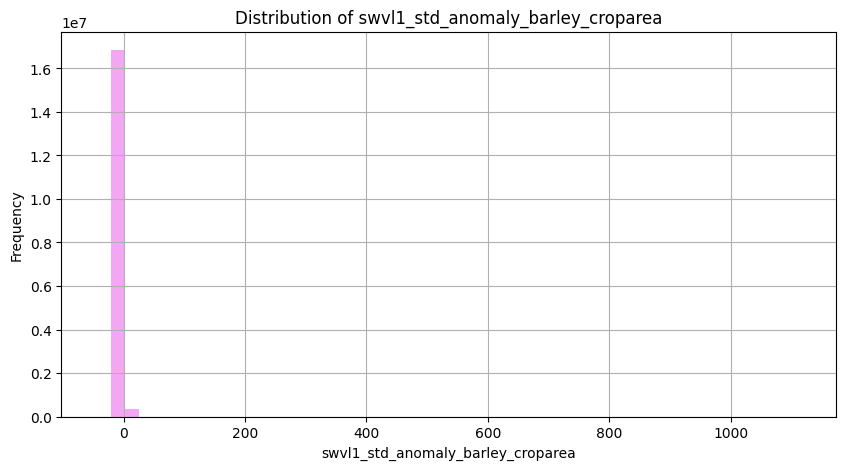

In [118]:
# To plot all variables
plot_variable_distributions(ds)

### Correlation

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_variable_correlation_heatmap(ds: xr.Dataset) -> None:
    """
    Generates a heatmap of correlations between variables in an xarray.Dataset.

    Args:
        ds (xr.Dataset): The input dataset containing multiple variables.
    
    Example:
        plot_variable_correlation_heatmap(ds)
    """
    
    # Aggregate data by taking the mean over spatial dimensions for each variable
    data_dict = {}
    for var_name, var_data in ds.data_vars.items():
        # Compute the mean across latitude and longitude to get a 1D time series
        time_series = var_data.mean(dim=["latitude", "longitude"], skipna=True)
        data_dict[var_name] = time_series.values

    # Convert to DataFrame for correlation calculation
    df = pd.DataFrame(data_dict, index=ds.valid_time.values)
    
    # Calculate correlation matrix
    corr_matrix = df.corr()

    # Plot heatmap of the correlation matrix with enhanced readability
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        square=True,
        cbar_kws={"shrink": 0.8},
        linewidths=0.5,
        annot_kws={"size": 8}
    )
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.title("Correlation Heatmap of Dataset Variables", fontsize=14)
    plt.show()


In [ ]:
plot_variable_correlation_heatmap(ds)

## Descriptive Statistics

### Summmary statistics

In [25]:
ds

<xarray.Dataset> Size: 103GB
Dimensions:                                  (valid_time: 551, latitude: 721,
                                              longitude: 1440)
Coordinates:
    number                                   int64 8B 0
  * valid_time                               (valid_time) datetime64[ns] 4kB ...
  * latitude                                 (latitude) float64 6kB 90.0 ... ...
  * longitude                                (longitude) float64 12kB 0.0 ......
    expver                                   (valid_time) <U4 9kB dask.array<chunksize=(45,), meta=np.ndarray>
    month                                    (valid_time) int64 4kB 1 2 ... 11
    lat                                      (latitude) float64 6kB 90.0 ... ...
    lon                                      (longitude) float64 12kB 0.0 ......
Data variables: (12/45)
    cl                                       (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    cvh                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    tvh                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    asn                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    sst                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    slt                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    ...                                       ...
    t2m_std_anomaly_barley_croparea          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    pev_barley_croparea                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    pev_std_anomaly_barley_croparea          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    swvl1_barley_croparea                    (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    swvl1_percent_of_normal_barley_croparea  (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    swvl1_std_anomaly_barley_croparea        (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [28]:
import xarray as xr
import pandas as pd
import numpy as np

def generate_summary_statistics(ds: xr.Dataset, variable_name: str = None) -> pd.DataFrame:
    """
    Generates summary statistics for a specific variable or all variables in an xarray.Dataset.

    Args:
        ds (xr.Dataset): The input dataset containing multiple variables.
        variable_name (str, optional): The name of the variable for which to compute statistics.
                                       If None, statistics for all variables will be computed.

    Returns:
        pd.DataFrame: A DataFrame with summary statistics for the selected variable or all variables, 
                      including mean, median, min, max, std, and NaN count.
    
    Example:
        summary_df = generate_summary_statistics(ds)
        summary_df_single = generate_summary_statistics(ds, variable_name="temperature")
    """
    # Initialize an empty dictionary to store summary statistics
    stats = {
        "Variable": [],
        "Mean": [],
        "Median": [],
        "Min": [],
        "Max": [],
        "Std": [],
        "NaN Count": []
    }

    # Helper function to calculate statistics for a single variable
    def calculate_stats(var_name, var_data):
        flat_data = var_data.values.flatten()
        stats["Variable"].append(var_name)
        stats["Mean"].append(float(var_data.mean().values))
        stats["Median"].append(float(np.nanmedian(flat_data)))
        stats["Min"].append(float(var_data.min().values))
        stats["Max"].append(float(var_data.max().values))
        stats["Std"].append(float(var_data.std().values))
        stats["NaN Count"].append(int(np.isnan(flat_data).sum()))

    if variable_name:
        # Validate that the variable exists in the dataset
        if variable_name not in ds.data_vars:
            raise ValueError(f"Variable '{variable_name}' not found in the dataset.")
        calculate_stats(variable_name, ds[variable_name])
    else:
        # Calculate statistics for all variables
        for var_name, var_data in ds.data_vars.items():
            calculate_stats(var_name, var_data)

    # Convert the dictionary to a DataFrame for readability
    summary_df = pd.DataFrame(stats)
    
    return summary_df


In [29]:
import xarray as xr
import pandas as pd
import numpy as np

def generate_summary_statistics_dask(ds: xr.Dataset, variable_name: str = None) -> pd.DataFrame:
    """
    Generates summary statistics for a specific variable or all variables in an xarray.Dataset using Dask for efficiency.

    Args:
        ds (xr.Dataset): The input dataset containing multiple variables.
        variable_name (str, optional): The name of the variable for which to compute statistics.
                                       If None, statistics for all variables will be computed.

    Returns:
        pd.DataFrame: A DataFrame with summary statistics for the selected variable or all variables, 
                      including mean, median, min, max, std, and NaN count.
    """
    # Initialize an empty dictionary to store summary statistics
    stats = {
        "Variable": [],
        "Mean": [],
        "Median": [],
        "Min": [],
        "Max": [],
        "Std": [],
        "NaN Count": []
    }

    # Helper function to calculate statistics for a single variable
    def calculate_stats(var_name, var_data):
        flat_data = var_data.data.flatten()  # Use Dask's data
        stats["Variable"].append(var_name)
        stats["Mean"].append(var_data.mean().compute().item())
        stats["Median"].append(float(np.nanmedian(flat_data.compute())))
        stats["Min"].append(var_data.min().compute().item())
        stats["Max"].append(var_data.max().compute().item())
        stats["Std"].append(var_data.std().compute().item())
        stats["NaN Count"].append(int(var_data.isnull().sum().compute().item()))

    if variable_name:
        # Validate that the variable exists in the dataset
        if variable_name not in ds.data_vars:
            raise ValueError(f"Variable '{variable_name}' not found in the dataset.")
        calculate_stats(variable_name, ds[variable_name])
    else:
        # Calculate statistics for all variables
        for var_name, var_data in ds.data_vars.items():
            calculate_stats(var_name, var_data)

    # Convert the dictionary to a DataFrame for readability
    summary_df = pd.DataFrame(stats)
    
    return summary_df


In [30]:
summary_stats = generate_summary_statistics(ds)

In [31]:
summary_stats

,Variable,Mean,Median,Min,Max,Std,NaN Count
0,cl,0.006675,0.000000,0.000000e+00,1.000000e+00,4.607952e-02,0
1,cvh,0.082977,0.000000,0.000000e+00,1.000000e+00,2.461294e-01,0
2,tvh,1.825908,0.000000,0.000000e+00,1.900000e+01,5.128872e+00,0
3,asn,0.865762,0.880000,5.199999e-01,8.800077e-01,4.226979e-02,0
4,sst,189.659592,273.968506,0.000000e+00,3.096814e+02,1.361271e+02,0
5,slt,0.671214,0.000000,0.000000e+00,7.000000e+00,1.167442e+00,0
6,lai_hv,0.439633,0.000000,0.000000e+00,7.085205e+00,1.152622e+00,0
7,tclw,0.047487,0.043900,0.000000e+00,7.841034e-01,3.896172e-02,0
8,tciw,0.022511,0.020302,0.000000e+00,3.624653e-01,1.730011e-02,0
9,z,3723.798096,2.490723,-1.386494e+03,5.745817e+04,8.349339e+03,0
